In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('cuda_ad_rgb')
import plugins

# Debug
# dr.set_flag(dr.JitFlag.VCallRecord, False)
# dr.set_flag(dr.JitFlag.LoopRecord, False)



[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!


In [2]:
# Simple code to test the implementation
bsdf = plugins.RednerMat(mi.Properties())
print(bsdf) # Show the default parameters

RednerMat[
    albedo=UniformSpectrum[value=[0.1]],
    roughness=UniformSpectrum[value=[0.1]],
    specular=UniformSpectrum[value=[0.1]],
]


In [3]:
# Simple test of eval, pdf and samples

# Test with fake intersection
si = dr.zeros(mi.SurfaceInteraction3f)
si.wi = mi.Vector3f([0, 0, 1])
ctx = mi.BSDFContext()

# Call eval, pdf, samples
print(bsdf.eval(ctx, si, mi.Vector3f([0, 0, 1])))
print(bsdf.pdf(ctx, si, mi.Vector3f([0, 0, 1])))
print(bsdf.sample(ctx, si, 0.5, mi.Point2f(0.5)))

[[0.11140845715999603, 0.11140845715999603, 0.11140845715999603]]
[0.5570423007011414]
(BSDFSample[
  wo = [[-0.49993, -4.37053e-08, 0.866066]],
  pdf = [0.351061],
  eta = [1],
  sampled_type = TODO,
  sampled_component = [1]
], [[0.20000006258487701, 0.20000006258487701, 0.20000006258487701]])


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Code which will plot the eval and PDF distribution
def sph_to_dir(theta, phi):
    """Map spherical to Euclidean coordinates"""
    st, ct = dr.sincos(theta)
    sp, cp = dr.sincos(phi)
    return mi.Vector3f(cp * st, sp * st, ct)

def plot_dist(values):
    """values needs to be an numpy float array"""
    values_r = values.reshape(2 * res, res).T

    # Plot values for spherical coordinates
    fig, ax = plt.subplots(figsize=(8, 4))

    im = ax.imshow(values_r, extent=[0, 2 * np.pi, np.pi, 0], cmap='jet')

    ax.set_xlabel(r'$\phi_o$', size=10)
    ax.set_xticks([0, dr.pi, dr.two_pi])
    ax.set_xticklabels(['0', '$\\pi$', '$2\\pi$'])
    ax.set_ylabel(r'$\theta_o$', size=10)
    ax.set_yticks([0, dr.pi / 2, dr.pi])
    ax.set_yticklabels(['0', '$\\pi/2$', '$\\pi$']);

si = dr.zeros(mi.SurfaceInteraction3f)

# Specify an incident direction with 45 degrees elevation
si.wi = sph_to_dir(dr.deg2rad(45.0), 0.0)

# Create grid in spherical coordinates and map it onto the sphere
res = 300
theta_o, phi_o = dr.meshgrid(
    dr.linspace(mi.Float, 0,     dr.pi,     res),
    dr.linspace(mi.Float, 0, 2 * dr.pi, 2 * res)
)
wo = sph_to_dir(theta_o, phi_o)

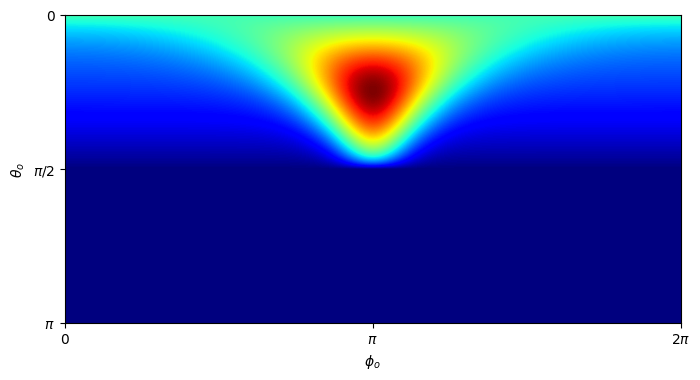

In [5]:
# Plot eval
plot_dist(np.array(bsdf.eval(mi.BSDFContext(), si, wo))[:, 0])


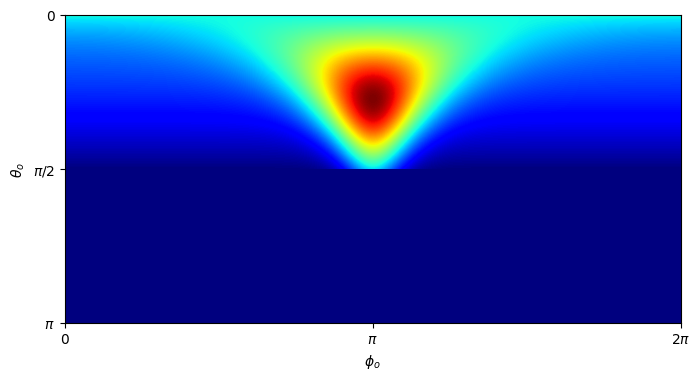

In [6]:
# Plot eval
plot_dist(np.array(bsdf.pdf(mi.BSDFContext(), si, wo)))

/tmp/ipykernel_9531/3959060315.py:1: RuntimeWarning: invalid value encountered in divide
  ratio = np.array(bsdf.eval(mi.BSDFContext(), si, wo))[:, 0] / np.array(bsdf.pdf(mi.BSDFContext(), si, wo))


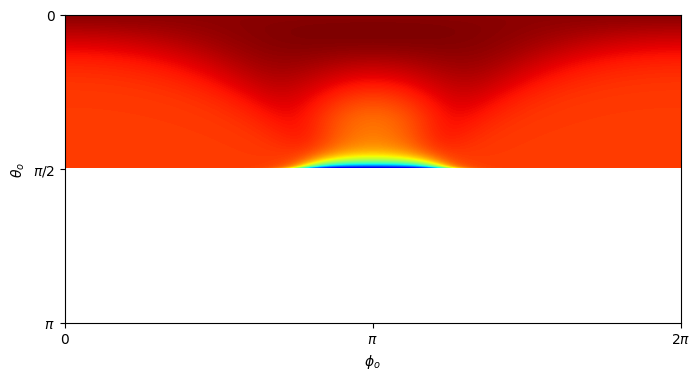

In [7]:
ratio = np.array(bsdf.eval(mi.BSDFContext(), si, wo))[:, 0] / np.array(bsdf.pdf(mi.BSDFContext(), si, wo))
plot_dist(ratio)

In [8]:
# <float name="roughness" value="0.05"/>
# <rgb name="albedo" value="1.0"/>
# <rgb name="specular" value="0.0"/>
xml = """""" 
sample_func, pdf_func = mi.chi2.BSDFAdapter("rednermat", xml)

chi2 = mi.chi2.ChiSquareTest(
    domain=mi.chi2.SphericalDomain(),
    sample_func=sample_func,
    pdf_func=pdf_func,
    sample_dim=3, # 3 random numbers
    ires=16,
    res=201
)

assert chi2.run()

chi2._dump_tables()

Pooled 500 low-valued cells into 182 cells to ensure sufficiently high expected cell frequencies
Histogram sum = 0.999487 (2.51 ms), PDF sum = 0.999516 (3.00 ms)
Chi^2 statistic = 9601.321234 (d.o.f = 9781)
Accepted the null hypothesis (p-value = 0.901100, significance level = 0.010000)



In [9]:
# wi = dr.normalize(mi.Vector3f([0.2, 0.6, 0.5]))
# sample_func, pdf_func = mi.chi2.BSDFAdapter("rednermat", xml, wi=wi)
# chi2 = mi.chi2.ChiSquareTest(
#     domain=mi.chi2.SphericalDomain(),
#     sample_func=sample_func,
#     pdf_func=pdf_func,
#     sample_dim=3, # 3 random numbers
#     ires=16,
#     res=201
# )

# assert chi2.run()

# chi2._dump_tables()

In [10]:
scene = mi.load_file("./scenes/cbox_redner_target.xml")
params_ref =  mi.traverse(scene)
image_ref = mi.render(scene, spp=2560)

mi.util.convert_to_bitmap(image_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

In [11]:
def mse(image):
    return dr.mean(dr.sqr(image - image_ref))

# Load the test scene
scene = mi.load_file("./scenes/cbox_redner.xml")
params = mi.traverse(scene)
print(params)

keys = ["glass.albedo.value", "glass.specular.value", "glass.roughness.value",
        "mirror.albedo.value", "mirror.specular.value", "mirror.roughness.value"]

opt = mi.ad.Adam(lr=0.05)
for k in keys:
    opt[k] = params[k]
params.update(opt);
errors = {}
for k in keys:
    errors[k] = []
    
image_final = mi.render(scene, spp=128)
mi.util.convert_to_bitmap(image_final)

SceneParameters[
  ------------------------------------------------------------------------------------
  Name                             Flags    Type           Parent
  ------------------------------------------------------------------------------------
  sensor.near_clip                          float          PerspectiveCamera
  sensor.far_clip                           float          PerspectiveCamera
  sensor.shutter_open                       float          PerspectiveCamera
  sensor.shutter_open_time                  float          PerspectiveCamera
  sensor.film.size                          ScalarVector2u HDRFilm
  sensor.film.crop_size                     ScalarVector2u HDRFilm
  sensor.film.crop_offset                   ScalarPoint2u  HDRFilm
  sensor.x_fov                     ∂, D     Float          PerspectiveCamera
  sensor.to_world                  ∂, D     Transform4f    PerspectiveCamera
  gray.reflectance.value           ∂        Color3f        SRGBReflectanceSpectr

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

Iteration 199: parameter error = 2.162176
Optimization complete.


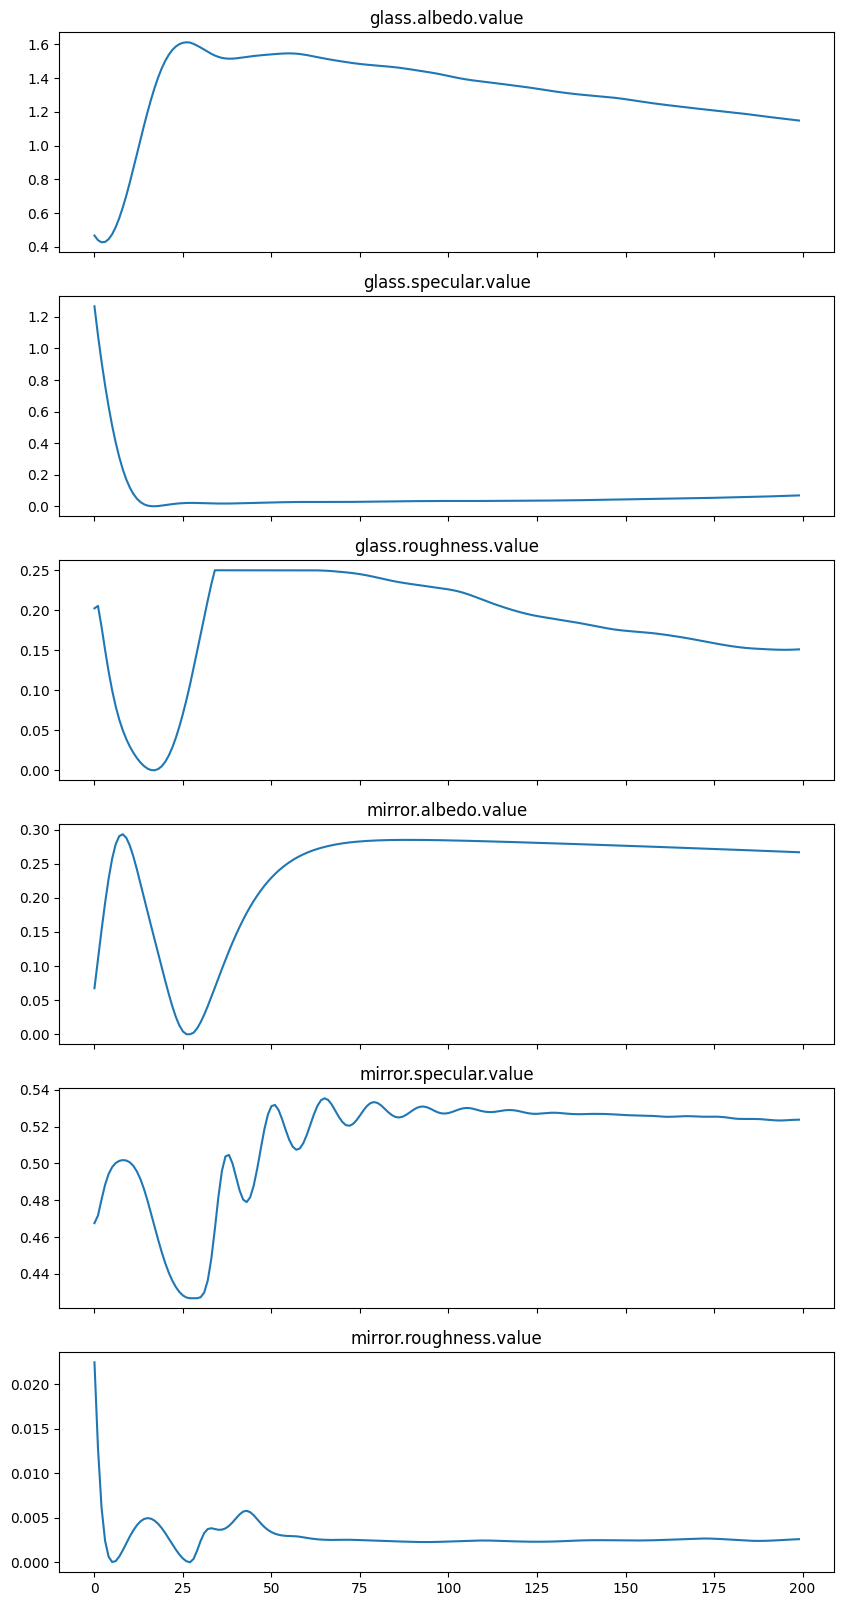

In [12]:
iteration_count = 200
for it in range(iteration_count):
    # Perform a (noisy) differentiable rendering of the scene
    image = mi.render(scene, params, spp=4)

    # Evaluate the objective function from the current rendered image
    loss = mse(image)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    for k in keys:
        opt[k] =     dr.clamp(opt[k], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)

    # Track the difference between the current color and the true value
    err_ref = 0.0
    for k in keys:
        v = dr.sum(dr.sqr(params_ref[k] - params[k]))
        errors[k] += [v]
        err_ref += v
    print(f"Iteration {it:02d}: parameter error = {err_ref[0]:6f}", end='\r')
print('\nOptimization complete.')

fig, axs = plt.subplots(len(keys), sharex=True, sharey=False, figsize=(10,20))
for (i, k) in enumerate(keys):
    axs[i].plot(errors[k])
    axs[i].set_title(k)

In [14]:
image_final = mi.render(scene, spp=128)
mi.util.convert_to_bitmap(image_final)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]